In [1]:
import os
import sys
import re
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.normalization import tpm

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2018-11-19 
Git hash:


In [47]:
ptrap = pd.read_parquet('../output/paper_submission/ptrap_scores.parquet')
ptrap.index = ptrap.index.droplevel('gene_symbol')
ptrap_fbgn = ptrap.index.get_level_values('FBgn').tolist()

In [89]:
biomarkers = nbconfig.seurat.get_biomarkers('res.0.6')
biomarkers = biomarkers.query('cluster != 9 & cluster != 10 & cluster != 11')
biomarkers = biomarkers[biomarkers.index.isin(ptrap_fbgn)].copy()
biomarkers.cluster = biomarkers.cluster.map(lambda x: nbconfig.cluster_annot[x])

In [90]:
biomarkers.groupby('FBgn').size()

FBgn
FBgn0000416    3
FBgn0000636    1
FBgn0002945    1
FBgn0003475    1
FBgn0004885    1
FBgn0010473    1
FBgn0011206    2
FBgn0011725    3
FBgn0012037    1
FBgn0013469    1
FBgn0026370    2
FBgn0026533    1
FBgn0026573    2
FBgn0027598    2
FBgn0030505    2
FBgn0030520    5
FBgn0032771    3
FBgn0034282    2
FBgn0039044    1
FBgn0039754    1
FBgn0041182    2
FBgn0050418    1
FBgn0085370    2
FBgn0087008    1
FBgn0259221    1
FBgn0261885    2
FBgn0262519    2
FBgn0264494    1
FBgn0264953    1
FBgn0264975    2
FBgn0265487    1
dtype: int64

In [104]:
singles = []
multis = []
for g, dd in biomarkers.groupby('FBgn'):
    if dd.shape[0] == 1:
        singles.append((g, dd.cluster.values[0]))
    else:
        multis.append((g, dd.cluster.values))

In [105]:
singles = pd.DataFrame(singles, columns=['FBgn', 'cluster']).set_index('FBgn')
singles = singles.sort_values(by='cluster')

multis = pd.DataFrame(multis, columns=['FBgn', 'clusters']).set_index('FBgn')

In [124]:
singles.sort_index()

,cluster
FBgn,
FBgn0000636,Terminal Epithelium
FBgn0002945,Pigment Cells
FBgn0003475,Mid 1º Spermatocytes
FBgn0004885,Pigment Cells
FBgn0010473,Terminal Epithelium
FBgn0012037,Mid 1º Spermatocytes
FBgn0013469,Spermatogonia
FBgn0026533,Spermatogonia
FBgn0039044,Spermatogonia


In [117]:
pd.options.display.max_colwidth = 1000

In [120]:
multis

,clusters
FBgn,
FBgn0000416,"[Late Cyst Cells, Pigment Cells, Early Cyst Cells]"
FBgn0011206,"[Early 1º Spermatocytes, Mid 1º Spermatocytes]"
FBgn0011725,"[Early 1º Spermatocytes, Late 1º Spermatocytes, Mid 1º Spermatocytes]"
FBgn0026370,"[Early 1º Spermatocytes, Spermatogonia]"
FBgn0026573,"[Early 1º Spermatocytes, Spermatogonia]"
FBgn0027598,"[Early 1º Spermatocytes, Pigment Cells]"
FBgn0030505,"[Late Cyst Cells, Terminal Epithelium]"
FBgn0030520,"[Late Cyst Cells, Spermatogonia, Mid Cyst Cells, Early Cyst Cells, Terminal Epithelium]"
FBgn0032771,"[Late 1º Spermatocytes, Mid 1º Spermatocytes, Early 1º Spermatocytes]"


In [110]:
raw = pd.read_parquet('../output/scrnaseq-wf/raw_by_cluster.parquet', columns=nbconfig.sel_cluster_order)
raw['Cyst Cells'] = raw[nbconfig.sel_cluster_order[4:7]].sum(axis=1)
raw = raw.reindex(columns=ptrap.columns)

gene_lens = pd.read_csv('../output/gene_ts_lengths.tsv', sep='\t', index_col=0).gene_ts_length

In [111]:
_tpm = tpm(raw, gene_length=gene_lens).dropna()
_tpm = _tpm.reindex(singles.index.tolist())

In [112]:
tpm_rank = _tpm.rank(axis=1)
tpm_rank['source'] = 'expression'
tpm_rank.set_index('source', append=True, inplace=True)

In [114]:
ptrap_rank = ptrap.reindex(singles.index.tolist()).rank(axis=1)
ptrap_rank['source'] = 'ptrap'
ptrap_rank.set_index('source', append=True, inplace=True)

In [126]:
ptrap.reindex(singles.index.tolist()).sort_index()

,Spermatogonia,Early 1º Spermatocytes,Mid 1º Spermatocytes,Late 1º Spermatocytes,Cyst Cells,Pigment Cells,Terminal Epithelium
FBgn,,,,,,,
FBgn0000636,0.312500,0.937500,0.625000,1.250000,1.250000,0.625000,5.104167
FBgn0002945,1.250000,2.500000,3.333333,1.666667,1.875000,0.833333,1.250000
FBgn0003475,0.000000,0.625000,1.250000,1.250000,0.833333,0.000000,0.000000
FBgn0004885,0.625000,1.666667,1.875000,1.875000,0.833333,0.000000,1.875000
FBgn0010473,0.000000,0.625000,0.625000,0.625000,0.625000,0.000000,1.250000
FBgn0012037,1.250000,1.875000,3.333333,3.750000,4.166667,0.000000,0.000000
FBgn0013469,1.666667,3.333333,3.333333,3.333333,4.166667,2.500000,1.666667
FBgn0026533,7.500000,7.500000,7.500000,7.500000,3.750000,7.500000,3.750000
FBgn0039044,4.375000,3.125000,1.875000,0.000000,1.875000,0.625000,0.625000


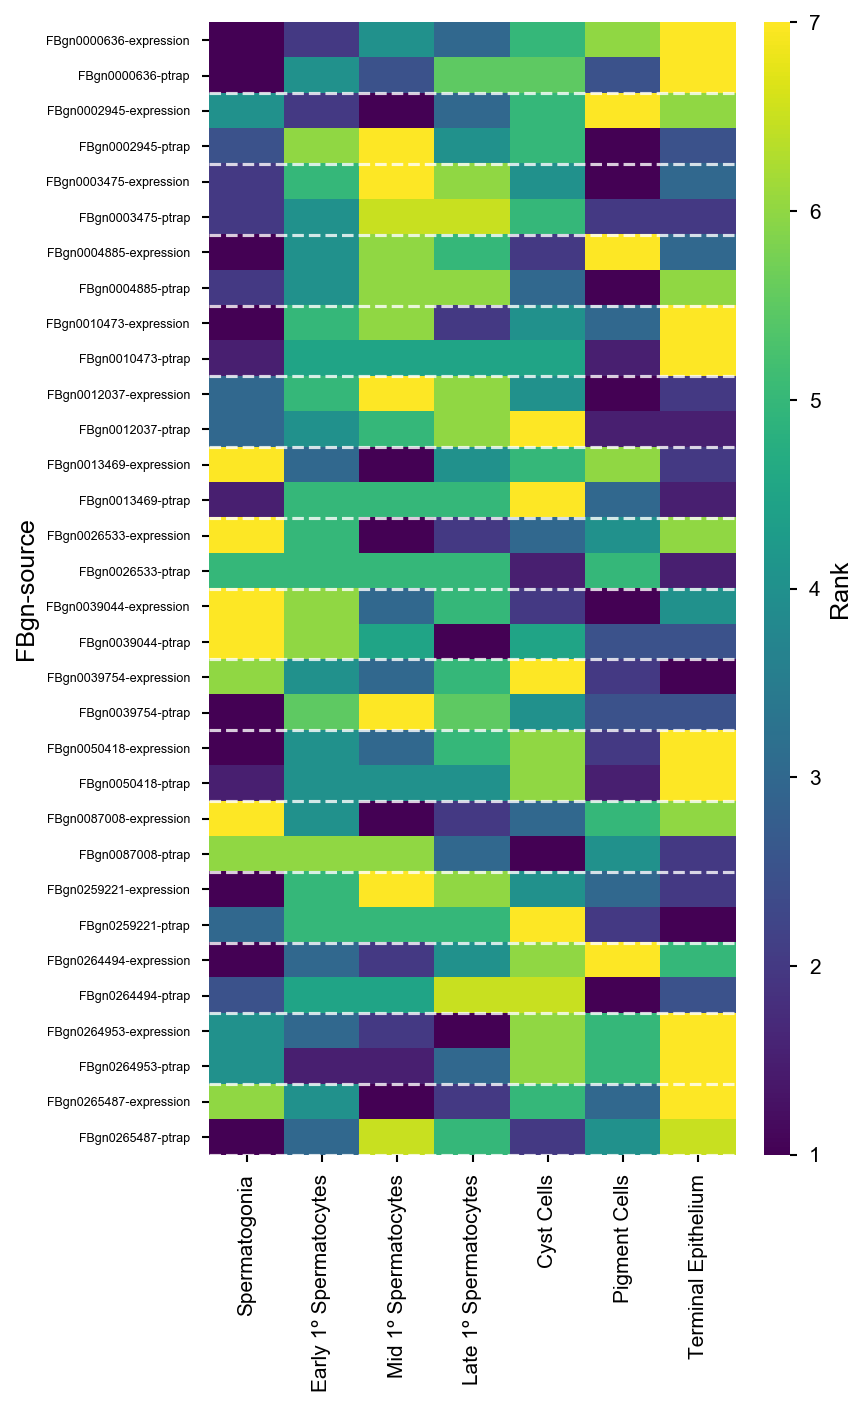

In [115]:
ranks = pd.concat([ptrap_rank, tpm_rank])
ranks.sort_index(inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 10), gridspec_kw=dict(width_ratios=[1, .05], wspace=.1))
sns.heatmap(ranks, yticklabels=True, cmap='viridis', ax=ax1, cbar_ax=ax2, cbar_kws={'label': 'Rank'})

plt.setp(ax1.get_yticklabels(), fontsize=6);

for n in np.arange(68, step=2):
    if n == 0:
        continue
    ax1.axhline(n, color='w', ls='--', alpha=.8)

In [133]:
multis.sort_index()

,clusters
FBgn,
FBgn0000416,"[Late Cyst Cells, Pigment Cells, Early Cyst Cells]"
FBgn0011206,"[Early 1º Spermatocytes, Mid 1º Spermatocytes]"
FBgn0011725,"[Early 1º Spermatocytes, Late 1º Spermatocytes, Mid 1º Spermatocytes]"
FBgn0026370,"[Early 1º Spermatocytes, Spermatogonia]"
FBgn0026573,"[Early 1º Spermatocytes, Spermatogonia]"
FBgn0027598,"[Early 1º Spermatocytes, Pigment Cells]"
FBgn0030505,"[Late Cyst Cells, Terminal Epithelium]"
FBgn0030520,"[Late Cyst Cells, Spermatogonia, Mid Cyst Cells, Early Cyst Cells, Terminal Epithelium]"
FBgn0032771,"[Late 1º Spermatocytes, Mid 1º Spermatocytes, Early 1º Spermatocytes]"


In [127]:
raw = pd.read_parquet('../output/scrnaseq-wf/raw_by_cluster.parquet', columns=nbconfig.sel_cluster_order)
raw['Cyst Cells'] = raw[nbconfig.sel_cluster_order[4:7]].sum(axis=1)
raw = raw.reindex(columns=ptrap.columns)

gene_lens = pd.read_csv('../output/gene_ts_lengths.tsv', sep='\t', index_col=0).gene_ts_length

In [128]:
_tpm = tpm(raw, gene_length=gene_lens).dropna()
_tpm = _tpm.reindex(multis.index.tolist())

In [129]:
tpm_rank = _tpm.rank(axis=1)
tpm_rank['source'] = 'expression'
tpm_rank.set_index('source', append=True, inplace=True)

In [130]:
ptrap_rank = ptrap.reindex(multis.index.tolist()).rank(axis=1)
ptrap_rank['source'] = 'ptrap'
ptrap_rank.set_index('source', append=True, inplace=True)

In [131]:
ptrap.reindex(multis.index.tolist()).sort_index()

,Spermatogonia,Early 1º Spermatocytes,Mid 1º Spermatocytes,Late 1º Spermatocytes,Cyst Cells,Pigment Cells,Terminal Epithelium
FBgn,,,,,,,
FBgn0000416,3.125000,3.750000,3.750000,5.000000,5.833333,2.500000,6.875000
FBgn0011206,0.000000,0.625000,2.500000,6.875000,0.000000,0.000000,0.000000
FBgn0011725,0.833333,0.833333,0.833333,0.833333,0.000000,0.000000,0.000000
FBgn0026370,5.625000,6.250000,6.875000,6.875000,3.125000,0.625000,0.625000
FBgn0026573,1.250000,3.750000,6.250000,6.875000,0.000000,0.000000,0.000000
FBgn0027598,1.666667,2.500000,2.500000,2.500000,3.333333,3.750000,4.166667
FBgn0030505,0.833333,0.833333,1.666667,1.875000,2.500000,4.166667,0.000000
FBgn0030520,7.500000,6.875000,6.250000,5.625000,6.875000,2.500000,7.500000
FBgn0032771,1.666667,2.500000,2.500000,2.500000,2.500000,0.000000,0.000000


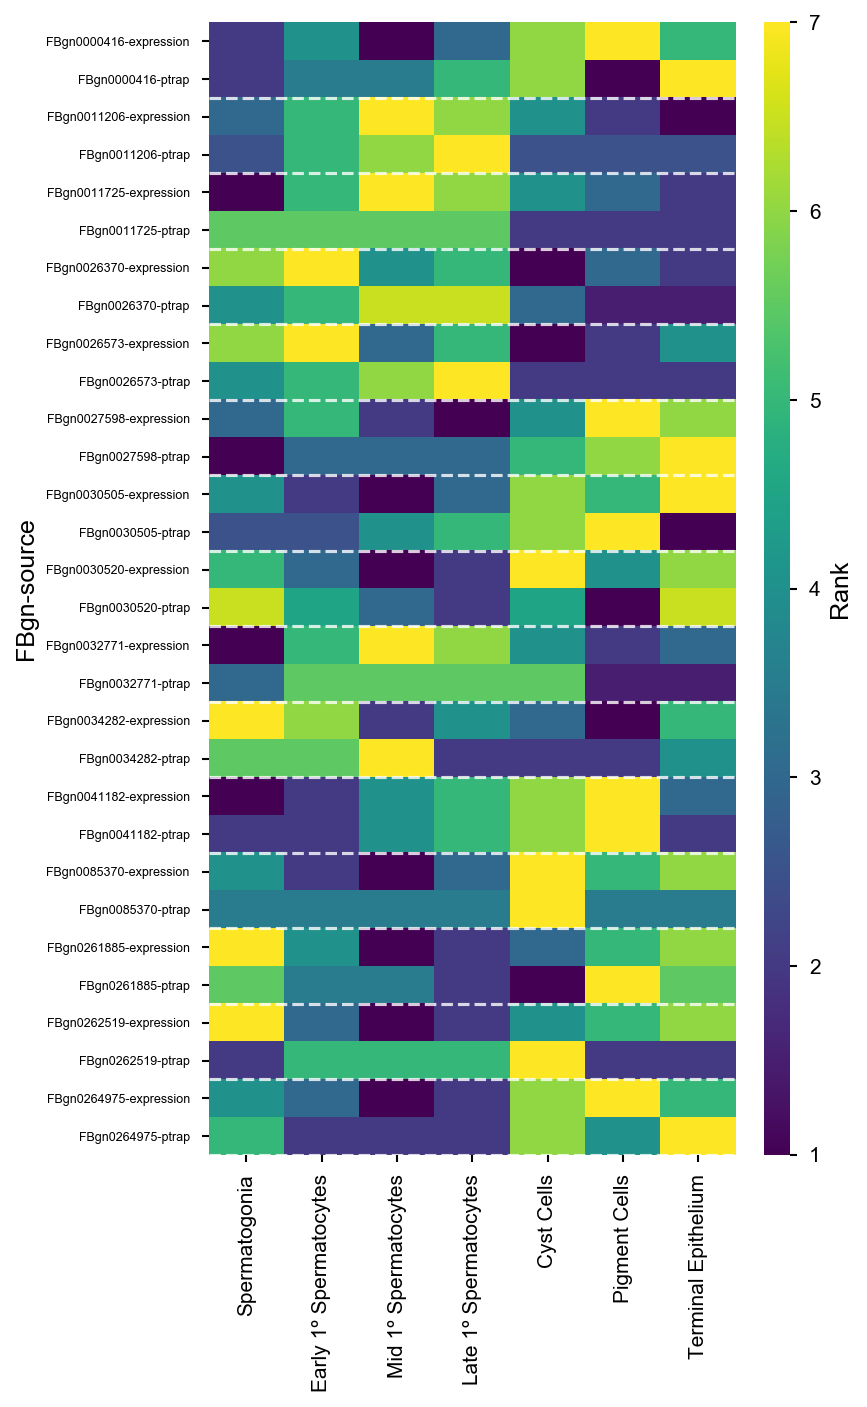

In [132]:
ranks = pd.concat([ptrap_rank, tpm_rank])
ranks.sort_index(inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 10), gridspec_kw=dict(width_ratios=[1, .05], wspace=.1))
sns.heatmap(ranks, yticklabels=True, cmap='viridis', ax=ax1, cbar_ax=ax2, cbar_kws={'label': 'Rank'})

plt.setp(ax1.get_yticklabels(), fontsize=6);

for n in np.arange(68, step=2):
    if n == 0:
        continue
    ax1.axhline(n, color='w', ls='--', alpha=.8)

In [12]:
gonia = biomarkers.query('cluster == 6').copy()
gonia.sort_values(['p_val_adj', 'avg_logFC'], inplace=True)
gonia['rank'] = range(1, gonia.shape[0] + 1)

In [29]:
raw = pd.read_parquet('../output/scrnaseq-wf/raw_by_cluster.parquet', columns=nbconfig.sel_cluster_order)

In [30]:
gonia = gonia.reindex(ptrap_fbgn).dropna().sort_values('rank')

In [31]:
gonia_srxs = gonia.index.tolist()

In [39]:
gonia_ptrap = ptrap[nbconfig.cluster_annot[6]].reindex(gonia_srxs).dropna()
gonia_raw = raw[nbconfig.cluster_annot[6]].reindex(gonia_srxs).dropna()

In [41]:
gonia_ptrap

FBgn
FBgn0013469    1.666667
FBgn0261885    6.250000
FBgn0262519    0.000000
FBgn0039044    4.375000
FBgn0026533    7.500000
FBgn0034282    5.833333
FBgn0087008    6.250000
FBgn0026370    5.625000
FBgn0026573    1.250000
FBgn0030520    7.500000
Name: Spermatogonia, dtype: float64

In [42]:
gonia_raw

FBgn
FBgn0013469     1027
FBgn0261885     1824
FBgn0262519     2319
FBgn0039044     1396
FBgn0026533     2473
FBgn0034282    11849
FBgn0087008      851
FBgn0026370     6980
FBgn0026573      935
FBgn0030520    15864
Name: Spermatogonia, dtype: int64

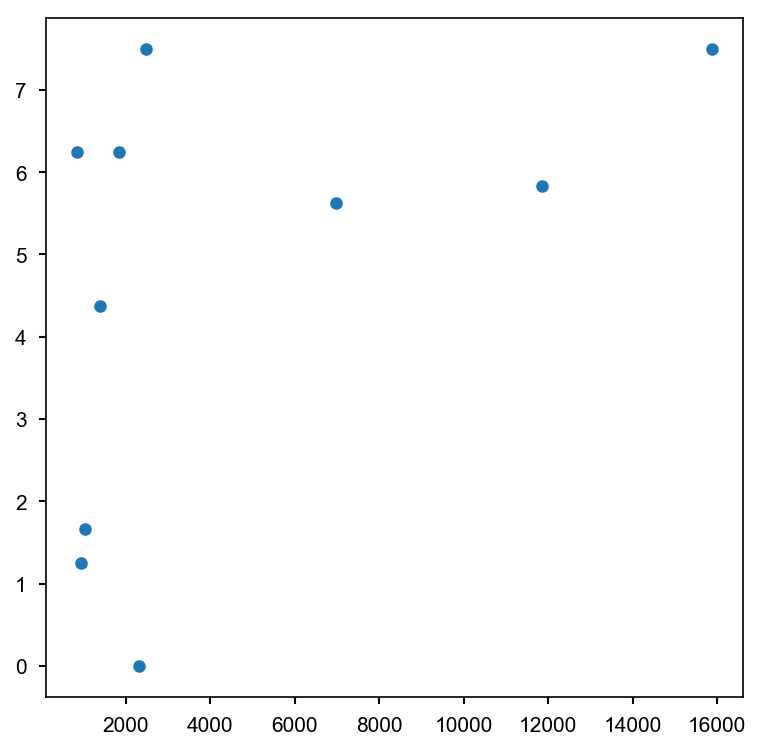

In [46]:
plt.scatter(gonia_raw, gonia_ptrap)

In [123]:
raw = pd.read_parquet('../output/scrnaseq-wf/raw_by_cluster.parquet', columns=nbconfig.sel_cluster_order)
raw['Cyst Cells'] = raw[nbconfig.sel_cluster_order[4:7]].sum(axis=1)
raw = raw.reindex(columns=ptrap.columns)

In [124]:
gene_lens = pd.read_csv('../output/gene_ts_lengths.tsv', sep='\t', index_col=0).gene_ts_length

In [125]:
_tpm = tpm(raw, gene_length=gene_lens).dropna()

In [126]:
_tpm = _tpm.reindex(ptrap_fbgn)

In [133]:
tpm_rank = _tpm.rank(axis=1)
tpm_rank['source'] = 'expression'
tpm_rank.set_index('source', append=True, inplace=True)

In [134]:
ptrap_rank = ptrap.rank(axis=1)
ptrap_rank['source'] = 'ptrap'
ptrap_rank.set_index('source', append=True, inplace=True)

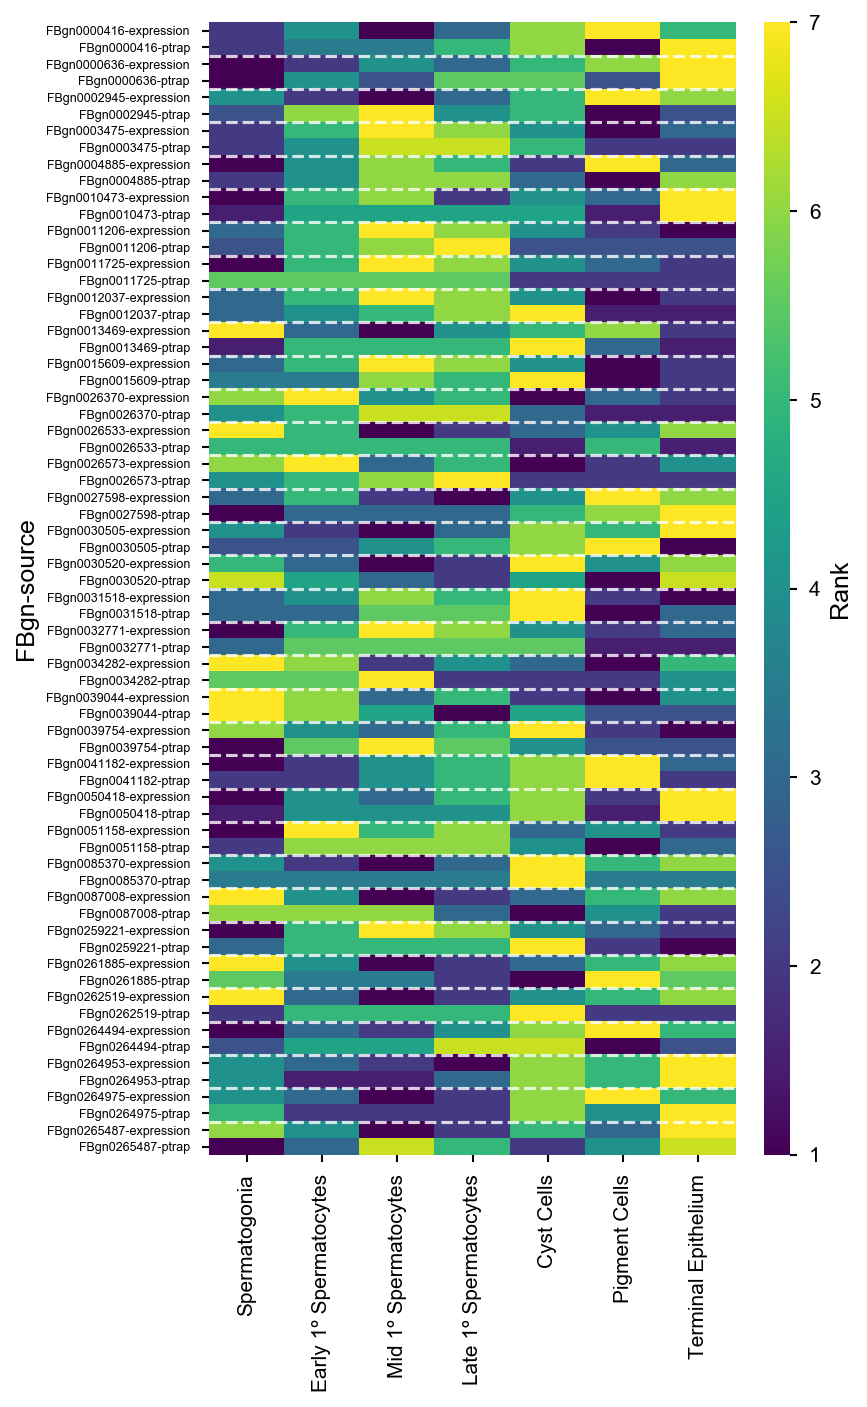

In [173]:
ranks = pd.concat([ptrap_rank, tpm_rank])
ranks.sort_index(inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 10), gridspec_kw=dict(width_ratios=[1, .05], wspace=.1))
sns.heatmap(ranks, yticklabels=True, cmap='viridis', ax=ax1, cbar_ax=ax2, cbar_kws={'label': 'Rank'})

plt.setp(ax1.get_yticklabels(), fontsize=6);

for n in np.arange(68, step=2):
    if n == 0:
        continue
    ax1.axhline(n, color='w', ls='--', alpha=.8)

In [ ]:
germ = nbconfig.sel_cluster_order[:4]

In [195]:
tpm_germ = _tpm.loc[:, germ]
ptrap_germ = ptrap.loc[:, germ]

In [249]:
tpm_bin = _tpm > 1
tpm_bin['source'] = 'expression'
tpm_bin.set_index('source', append=True, inplace=True)

In [250]:
ptrap_bin = ptrap > 1
ptrap_bin['source'] = 'ptrap'
ptrap_bin.set_index('source', append=True, inplace=True)

[Text(1,0,'Off'), Text(1,1,'On')]

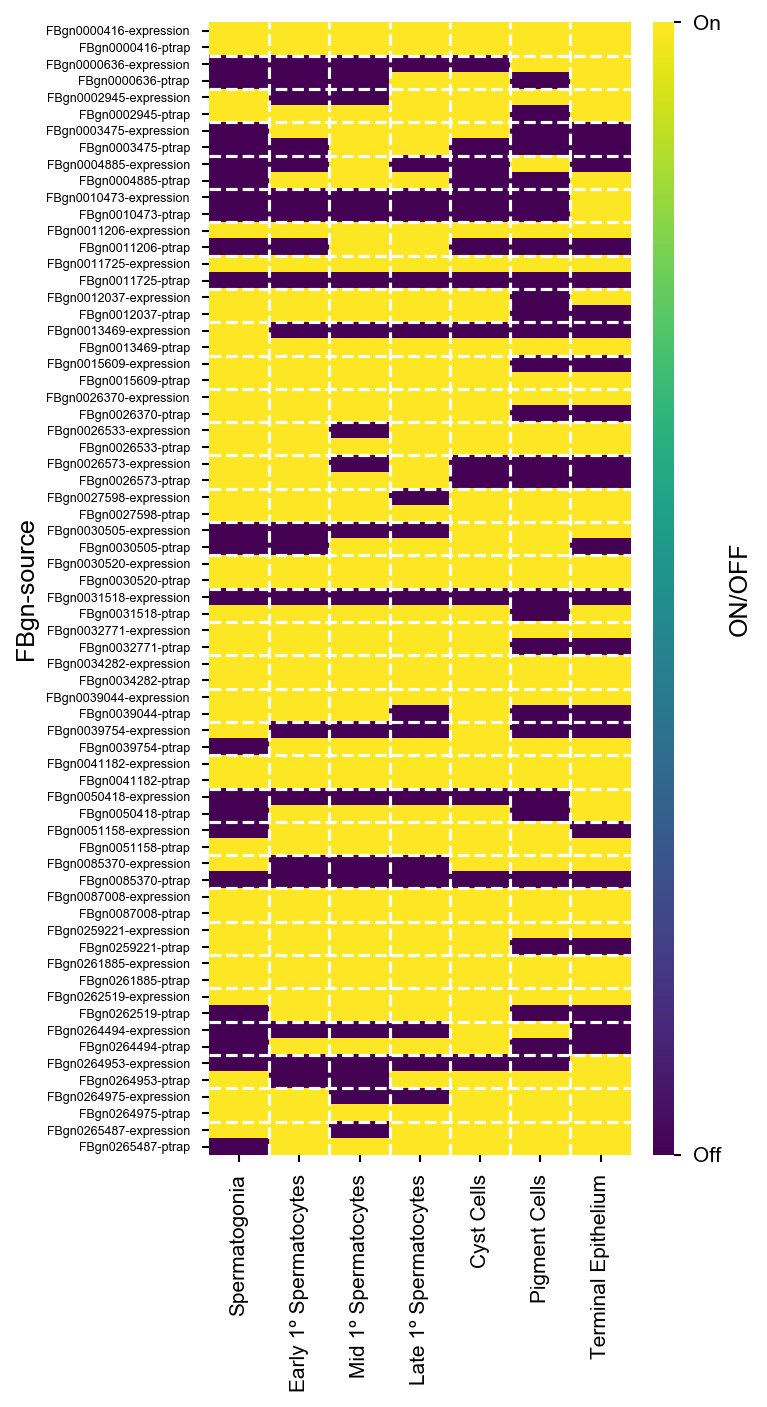

In [252]:
bins = pd.concat([ptrap_bin, tpm_bin])
bins.sort_index(inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 10), gridspec_kw=dict(width_ratios=[1, .05], wspace=.1))
sns.heatmap(bins, yticklabels=True, cmap='viridis', ax=ax1, cbar_ax=ax2, cbar_kws={'label': 'ON/OFF', 'ticks': [0, 1]})

plt.setp(ax1.get_yticklabels(), fontsize=6);

for n in np.arange(68, step=2):
    if n == 0:
        continue
    ax1.axhline(n, color='w', ls='--')
    
ax1.axvline(1, color='w', ls='--')
ax1.axvline(2, color='w', ls='--')
ax1.axvline(3, color='w', ls='--')
ax1.axvline(4, color='w', ls='--')
ax1.axvline(5, color='w', ls='--')
ax1.axvline(6, color='w', ls='--')

ax2.set_yticklabels(['Off', 'On'])